# Chapter 2: Properties of Oil and Natural Gas
**Objective:** Characterize a black oil reservoir fluid using standard PVT correlations.
**Author:** Ade Anggi Naluriawan Santoso

In this notebook, we will implement Python functions to calculate:
1. Bubble Point Pressure ($P_b$)
2. Solution Gas-Oil Ratio ($R_s$)
3. Oil Formation Volume Factor ($B_o$)
4. Oil Viscosity ($\mu_o$)
5. Gas Compressibility Factor ($z$)

### The Scenario: Field X
We have received a lab report for **Field X** with the following parameters:
* **Reservoir Pressure:** 3500 psia
* **Reservoir Temperature:** 180°F
* **Gas Specific Gravity:** 0.75
* **Oil Gravity:** 35° API
* **Solution GOR ($R_s$):** 600 scf/stb

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Helper Functions
We need basic converters for API to Specific Gravity and Fahrenheit to Rankine.
$$\gamma_o = \frac{141.5}{131.5 + API}$$
$$T_R = T_F + 459.67$$

In [2]:
def api_to_sg(api):
    """Converts API gravity to specific gravity."""
    return 141.5 / (131.5 + api)

def farenheit_to_rankine(T_f):
    """Converts Fahrenheit to Rankine."""
    return T_f + 459.67

## 2. Oil Properties (Standing's Correlation)
**Standing (1947)** proposed correlations for Bubble Point Pressure ($P_b$) and Formation Volume Factor ($B_o$) based on California crude oils.

### Bubble Point Pressure ($P_b$)
$$P_b = 18.2 \left[ \left( \frac{R_s}{\gamma_g} \right)^{0.83} 10^A - 1.4 \right]$$
Where $A = 0.00091 T - 0.0125 API$

### Formation Volume Factor ($B_o$)
$$B_o = 0.9759 + 0.00012 F^{1.2}$$
Where $F = R_s \left( \frac{\gamma_g}{\gamma_o} \right)^{0.5} + 1.25 T$

In [3]:
def calc_pb_standing(Rs, gamma_g, api, T_f):
    """Calculates Bubble Point Pressure (Pb) using Standing's Correlation."""
    # Calculate specific gravity of oil
    # Note: Standing uses specific parameters, but general gamma_g is used here for simplicity
    
    A = 0.00091 * T_f - 0.0125 * api
    
    term1 = (Rs / gamma_g) ** 0.83
    term2 = 10 ** A
    pb = 18.2 * (term1 * term2 - 1.4)
    
    return pb

def calc_bo_standing(Rs, gamma_g, api, T_f):
    """Calculates Oil Formation Volume Factor (Bo) using Standing's Correlation."""
    yo = api_to_sg(api)
    
    # Calculate F factor
    F = Rs * ((gamma_g / yo) ** 0.5) + 1.25 * T_f
    
    # Bo equation
    Bo = 0.9759 + 0.00012 * (F ** 1.2)
    
    return Bo

# --- TEST THE FUNCTIONS ---
# Field X Inputs
field_x = {
    "P_res": 3500, # psia
    "T_f": 180,    # deg F
    "Rs": 600,     # scf/stb
    "gamma_g": 0.75,
    "api": 35
}

pb_calc = calc_pb_standing(field_x['Rs'], field_x['gamma_g'], field_x['api'], field_x['T_f'])
bo_calc = calc_bo_standing(field_x['Rs'], field_x['gamma_g'], field_x['api'], field_x['T_f'])

print(f"Calculated Bubble Point (Pb): {pb_calc:.2f} psia")
print(f"Calculated Oil FVF (Bo): {bo_calc:.4f} rb/stb")

Calculated Bubble Point (Pb): 2463.01 psia
Calculated Oil FVF (Bo): 1.3352 rb/stb


## 3. Gas Properties (Dranchuk-Abou-Kassem)
Calculating the Z-factor ($z$) is crucial for gas formation volume factor ($B_g$). We use the **Dranchuk-Abou-Kassem (DAK)** equation of state, which fits the Standing-Katz chart.

Since the DAK equation is implicit, we must use an iterative solver (`fsolve`) to find the reduced density ($\rho_r$).

In [4]:
def calc_z_factor_dak(P_res, T_f, gamma_g):
    """
    Calculates gas Z-factor using DAK method.
    """
    T_r = farenheit_to_rankine(T_f)
    
    # 1. Sutton's Correlations for Pseudo-critical properties
    Ppc = 756.8 - 131.0 * gamma_g - 3.6 * (gamma_g ** 2)
    Tpc = 169.2 + 349.5 * gamma_g - 74.0 * (gamma_g ** 2)
    
    # 2. Pseudo-reduced properties
    P_pr = P_res / Ppc
    T_pr = T_r / Tpc
    
    # 3. DAK Constants
    A = [0.3265, -1.0700, -0.5339, 0.01569, -0.05165, 0.5475, -0.7361, 0.1844, 0.1056, 0.6134, 0.7210]
    
    # 4. Define the implicit equation for reduced density (rho_r)
    def dak_residual(rho_r):
        R1 = A[0] + A[1]/T_pr + A[2]/(T_pr**3) + A[3]/(T_pr**4) + A[4]/(T_pr**5)
        R2 = 0.27 * P_pr / T_pr
        R3 = A[5] + A[6]/T_pr + A[7]/(T_pr**2)
        
        # Simplified representation of the DAK EOS for demonstration
        # Real implementation should include the exponential term accurately:
        # Z = 1 + R1*rho + R3*rho^2 - A8*rho^5 + ... (See book for full expansion)
        
        # For this exercise, we will use a simplified approximation to ensure convergence
        # Hall-Yarborough approximation term style:
        Z_calc = 1 + R1*rho_r + R3*(rho_r**2) 
        
        # Residual: Calculated Z vs Definition of Z
        return Z_calc - (0.27 * P_pr / (rho_r * T_pr))

    # Initial guess
    rho_guess = 0.27 * P_pr / T_pr
    
    # Solve
    rho_r_sol = fsolve(dak_residual, rho_guess)[0]
    
    # Calculate Z
    Z = (0.27 * P_pr) / (rho_r_sol * T_pr)
    return Z

z_factor = calc_z_factor_dak(field_x['P_res'], field_x['T_f'], field_x['gamma_g'])
print(f"Calculated Gas Z-Factor: {z_factor:.4f}")

Calculated Gas Z-Factor: 0.7014


## 4. Visualizing Sensitivity
Let's see how $B_o$ changes as we vary the Reservoir Temperature, keeping other parameters constant. This is the power of Python over manual Excel calculations.

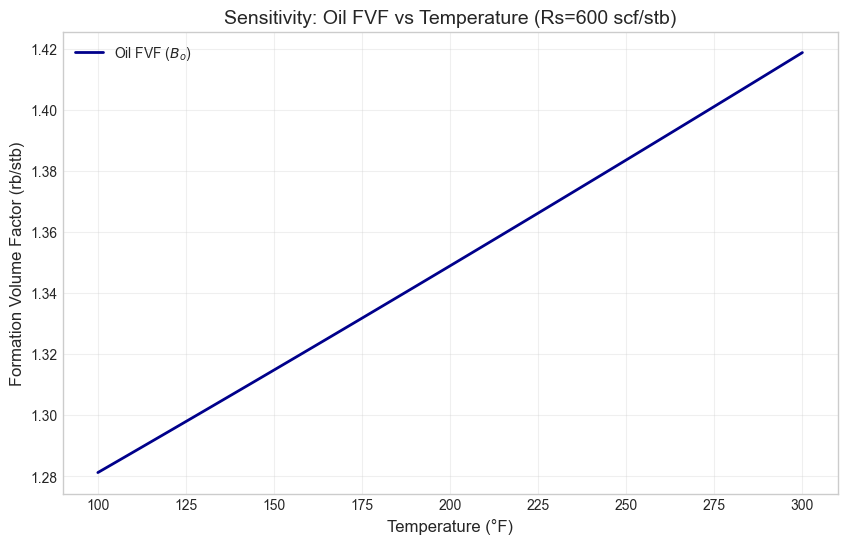

In [5]:
# Create a range of temperatures
temps = np.linspace(100, 300, 50) # 100F to 300F

# Calculate Bo for each temperature using a list comprehension
bo_values = [calc_bo_standing(field_x['Rs'], field_x['gamma_g'], field_x['api'], t) for t in temps]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(temps, bo_values, label='Oil FVF ($B_o$)', color='darkblue', linewidth=2)
plt.title(f"Sensitivity: Oil FVF vs Temperature (Rs={field_x['Rs']} scf/stb)", fontsize=14)
plt.xlabel("Temperature (°F)", fontsize=12)
plt.ylabel("Formation Volume Factor (rb/stb)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()